In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
from scipy.sparse.linalg import LinearOperator, cg
import networkx as nx

# №1

In [2]:
# TODO

<Figure size 360x360 with 0 Axes>

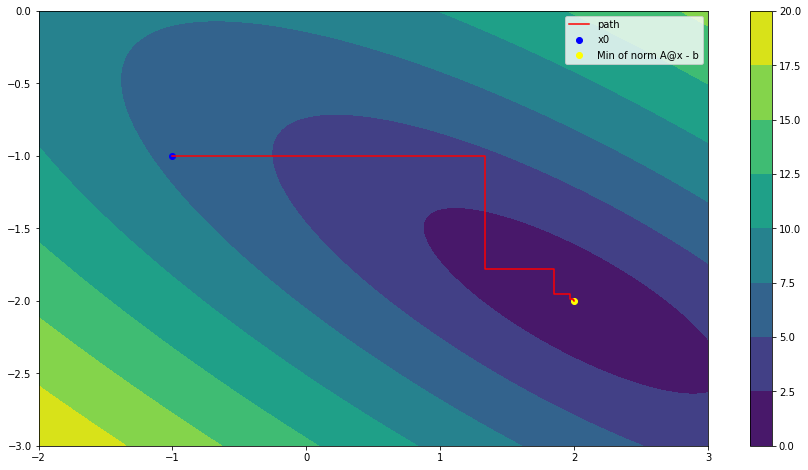

In [3]:
A = np.array([[3, 2], [2, 6]])
b = np.array([2, -8])
x0 = np.array([-1, -1])

def plot_path(xs: np.array):    
    x_range = np.linspace(min(xs[:,0]) - 1, max(xs[:,0]) + 1, 100)
    y_range = np.linspace(min(xs[:,1]) - 1, max(xs[:,1]) + 1, 100)
    X, Y = np.meshgrid(x_range, y_range)

    fig = plt.figure(figsize=(5, 5))
    Z = np.zeros((len(X), len(Y)))
    for i in range(len(X[0])):
        for j in range(len(Y[0])):
            Z[i, j] = np.linalg.norm(A@np.array([X[0][i], Y[:, 0][j]]) - b)
    
    plt.figure(figsize=(15, 8))
    cp = plt.contourf(X, Y, Z.T)
    plt.plot(xs[:, 0], xs[:, 1], color = 'red', label = "path")
    plt.scatter(x0[0], x0[1], label='x0', color = 'blue') 
    solution = np.linalg.inv(A) @ b
    plt.scatter(solution[0], solution[1], label='Min of norm A@x - b', color = 'yellow')
    fig.colorbar(cp)
    plt.legend()
    plt.show()

def steepest_descent(A: np.array, b: np.array, x0: np.array, n_steps: int = 100):
    x = x0.copy()
    xs = [x0]
    for i in range(n_steps+1):
        r = A.dot(x) - b
        tau = r.T.dot(r) / r.T.dot(A.dot(r))
        x = x - tau * r
        xs.append(x)
    return np.array(xs)

xs = steepest_descent(A, b, x0, 40) 
plot_path(xs)

<Figure size 360x360 with 0 Axes>

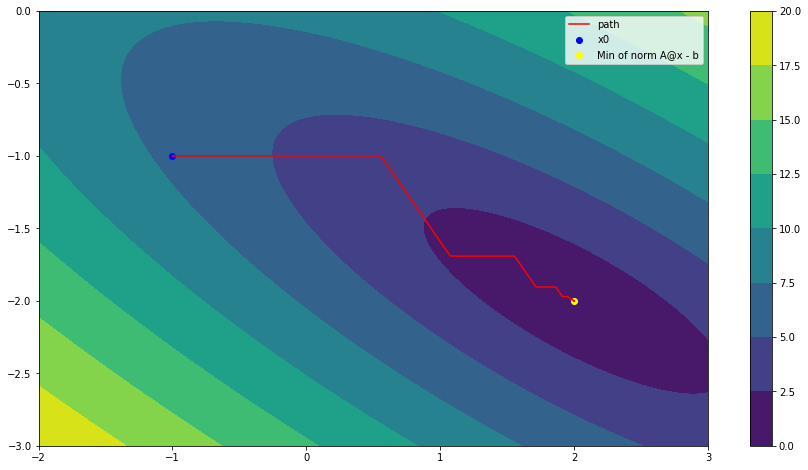

In [4]:
# протестируем на той же матрице A
def richardson(A: np.array, b: np.array, x0: np.array, n_steps: int = 100, tau: float = None):
    if not tau:
        eigen_values = np.linalg.eigvals(A)
        tau = 2/(np.min(eigen_values) + np.max(eigen_values))
    ones = np.diag(np.ones(len(A[0])))
    x = x0.copy()
    error = x0 - np.linalg.inv(A) @ b
    errors = [error]
    xs = [x0]
    for i in range(n_steps + 1):
        x = x - tau*(A@x - b)
        xs.append(x)
        error = (ones - tau*A)@error
        errors.append(error)
    return np.array(xs), np.array(errors)

xs, errors = richardson(A, b, x0, 50) 
plot_path(xs)

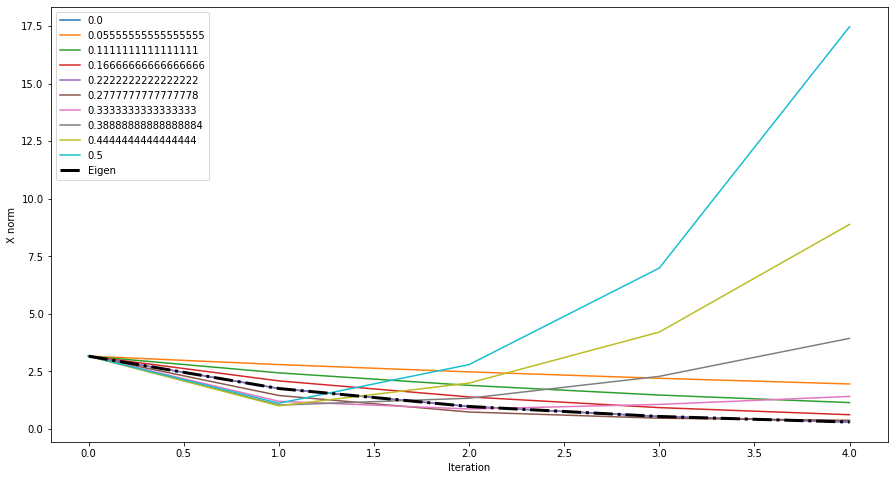

In [5]:
# видно, что при значениях меньше и больше 2/(eigen_min + eigen_max) алгоритм начинает расходиться
plt.figure(figsize=(15, 8))
for tt in np.linspace(0, 0.5, 10):
    _, errors_tmp = richardson(A, b, x0, 3, tt)
    plt.plot(np.linalg.norm(errors_tmp, axis = 1), label = tt)
_, errors_best = richardson(A, b, x0, 3)
plt.plot(np.linalg.norm(errors_best, axis = 1), label = "Eigen", color = "black", linestyle = "-.", linewidth = 3)
plt.ylabel("X norm")
plt.xlabel("Iteration")
plt.legend()
plt.show()

# №3

<Figure size 360x360 with 0 Axes>

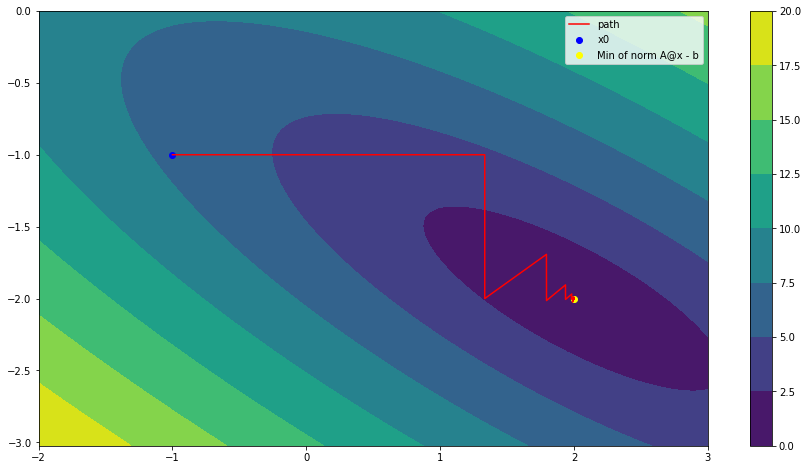

In [6]:
def conjagurate_gd(A: np.array, b: np.array, x0: np.array, n_steps: int = 100):
    x = x0.copy()
    xs = [x]
    r = A@x - b
    d = r.copy()
    ds = [d]
    alpha, beta = [], []
    for _ in range(n_steps + 1):
        alpha = (r.T@r)/(d.T@A@d)
        x = x - alpha * r
#         x = x + alpha * d
        xs.append(x)
        r_new = A@x - b
        beta = (r_new.T@r_new)/(r.T@r)
        d = r_new + beta * d
        ds.append(d)
        r = r_new
    return np.array(xs), np.array(ds)
     
xs, ds = conjagurate_gd(A, b, x0, 100)    
plot_path(xs)

In [7]:
# теперь посчитаем D как в задании
N = 3 # можно менять
D = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        D[i, j] = (ds[i].T@A@ds[j])
D

array([[ 1.47000000e+02,  3.55271368e-15,  6.06666667e+01],
       [ 1.24344979e-14,  1.01629630e+02, -2.07407407e+00],
       [ 6.06666667e+01, -2.07407407e+00,  2.50793651e+01]])

# №4

In [8]:
data = pd.read_pickle("data/data.pkl")
d, s, v, b = data["d"], data["s"], data["v"], data["b"]

v1 = np.array(v[:, 0])
v2 = np.array(v[:, 1])
# A = np.diag(d) + s[0]*v1@v1.T + s[1]*v2@v2.T # большая, но разреженная, решать обычным методом неоптимально
# np.linalg.matrix_rank(A) # не досчитывается :(

def matmul_custom(x):
    v1_, v2_ = v1 @ x, v2 @ x
    return np.multiply(x, d) + s[0]*v1_*v1 + s[1]*v2_*v2

A = LinearOperator((50000, 50000), matvec = matmul_custom)

x = cg(A, b, maxiter = 10000)[0]
print(np.linalg.norm(A@x - b) / np.linalg.norm(x))

0.03578224573980819


# №5

In [9]:
def woodbury(A: np.array, U: np.array, V: np.array):
    Ainv = np.linalg.inv(A)
    C = np.diag(np.ones(k))
    Ainv_U = Ainv@U
    return Ainv - Ainv_U@np.linalg.inv((C + V@Ainv_U))@V@Ainv

p, k = 5000, 100
A = 10 * np.diag(np.random.rand(p))
U = 1e-2 * np.random.rand(p, k)
V = 1e-2 * np.random.rand(k, p)

In [10]:
%time
wb_res = woodbury(A, U, V)

CPU times: user 9 µs, sys: 24 µs, total: 33 µs
Wall time: 8.11 µs


In [11]:
%time
inv_res = np.linalg.inv(A + U@np.diag(np.ones(k))@V) # дольше, так как тут больше раз обращаем матрицы

CPU times: user 9 µs, sys: 23 µs, total: 32 µs
Wall time: 11 µs


In [12]:
# одинаковые
np.array_equal(np.round(inv_res, 6),  np.round(wb_res, 6))

True

# №6

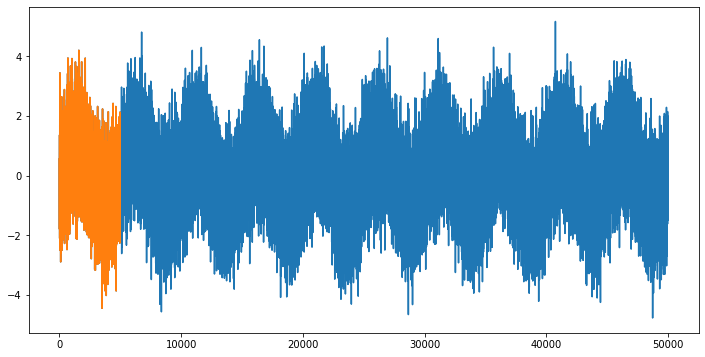

In [13]:
np.random.seed(42)
data = np.load('data/y.npy')
plt.figure(figsize=(12, 6))
plt.plot(data)
Y = np.reshape(data, (10, 5000))
plt.plot(Y[0])

$\textbf{Part 1}$

Нужно минимизировать:

$$ min_Y \left[ \sum_{i=0}^{t-1}|| y_i - Y_{i\ mod\ T}||^{2} \right]
  $$

Пусть

$$
P(Y) = \sum_{i=0}^{t-1}|| y_i - Y_{i\ mod\ T}||^{2} 
$$

$$
\frac{dP(Y)}{dY_i} = -2\sum_{i=0}^{t-1} (y_i - Y_{i\ mod\ T}) = 0
$$

Тогда:


$$\sum_{i=0}^{t-1}y_i = n \sum_{j=0}^{T-1} Y_j$$

$$
Y_{min_j} = \frac{1}{n}\sum_{i=0}^{n} y_{ji}
$$

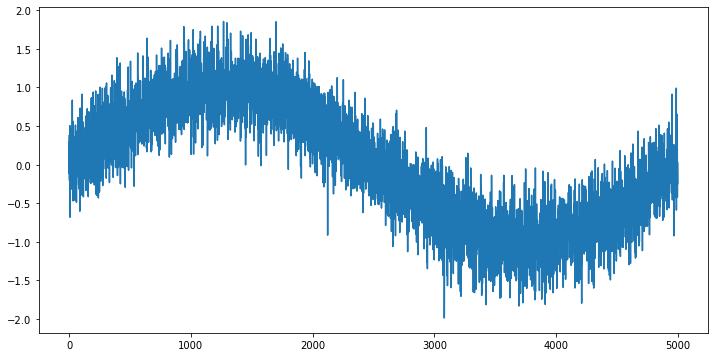

In [14]:
# Можем просто усреднить
plt.figure(figsize=(12, 6))
plt.plot(Y.mean(axis = 0))

$\textbf{Part 2}$

Теперь минимизируем:

$$
min_Y \left[ \sum_{i=0}^{t-1} || y_i - Y_{i\ mod\ T}||^{2} + \sum_{i=0}^{T-1}\gamma ||Y_i-Y_{i-1} ||^{2} \right]
$$

$$P(Y) = \sum_{i=0}^{t-1} || y_i - Y_{i\ mod\ T}||^{2} + \sum_{i=0}^{T-1}\gamma ||Y_i-Y_{i-1} ||^{2} $$

$$
\frac{d F}{d Y i}=- 2 \sum_{i=1}^{t - 1}\left(y_i - Y_{i\ mod\ T}\right)+2 \gamma\left(Y_i-Y_{i-1}\right)+2 \gamma\left(Y_{i+1}-Y_i\right)=0 
$$

Упростив:
$$
-\gamma Y_{i-1} + (n+2 \gamma)Y_i - \gamma Y_{i+1}=\sum_{i=0}^{t-1} y_{k i}
$$

$$ A[i, i-1],\ A[i, i],\ A[i, i+1] = -\gamma,\ (n+2 \gamma),\ -\gamma; \quad b_i = \sum_{k=1}^{n=10} y_{k i}$$

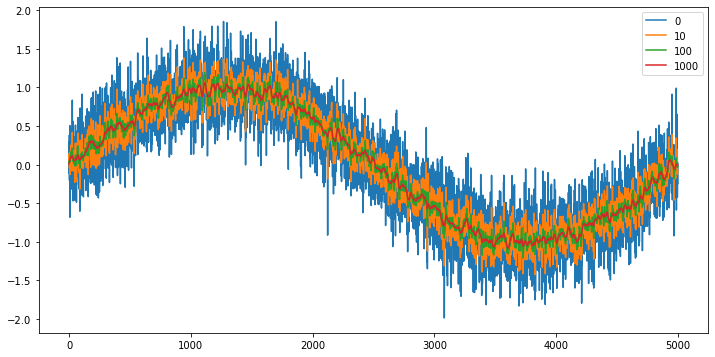

In [15]:
from scipy.sparse import dia_matrix

def smoothing(gamma):
    M = 5000
    n = 10
    arr = np.ones(M)
    diags = np.array([-gamma*arr, (n + 2*gamma)*arr, -gamma*arr])
    A = dia_matrix((diags, [-1,0,1]), shape=(M, M)).tocsr()
    b = Y.sum(axis=0)
    solution = cg(A, b, maxiter=100)
    plt.plot(solution[0], label = gamma)
    plt.legend()

plt.figure(figsize=(12, 6))
smoothing(0)
smoothing(10)
smoothing(100)
smoothing(1000)

# №7

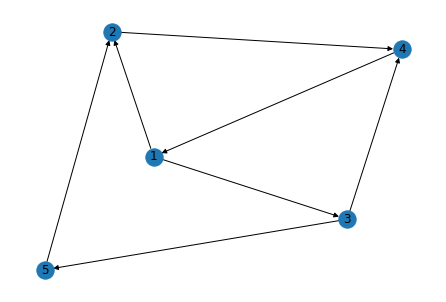

In [16]:
#пример графа
G = nx.DiGraph()
G.add_nodes_from([1, 2, 3, 4, 5])
G.add_edges_from([(1, 2), (1, 3), (3, 4), (4, 1), (2, 4), (5, 2), (3, 5)])
nx.draw(G, with_labels=True)
plt.show()

In [17]:
# как этот граф связей запишется в виде матрицы связей между компонентами
G =  np.array(
    [np.array([0, 1, 1, 0, 0]),
     np.array([0, 0, 0, 1, 0]),
     np.array([0, 0, 0, 1, 1]),
     np.array([1, 0 ,0, 0, 0]),
     np.array([0, 1, 0, 0, 0])])



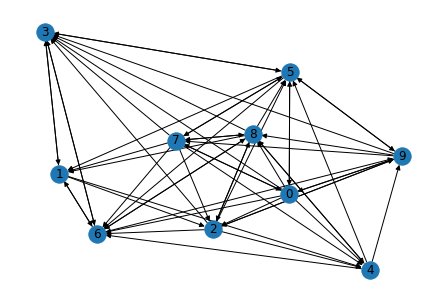

In [18]:
# теперь сгенерируем граф случайно, как в пункте 1 задания
def generate_connections_graph(n: int):
    graph = []
    l = []
    for i in range(n):
        edges = np.random.choice([0, 1], size = n)
        # убираем петли, если появляются
        edges[i] = 0
        l.append(edges)
        L_j = len(edges[edges == 1])
        edges = edges/L_j
        graph.append(edges)
    return np.array(graph), np.array(l)

N = 10
example_G, example_l = generate_connections_graph(N)
# большой граф связей
example_graph = nx.from_numpy_array(example_l, create_using=nx.DiGraph)
nx.draw(example_graph, with_labels=True)
plt.show()

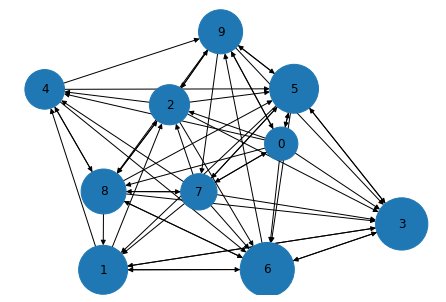

In [19]:
e = np.ones(N)
beta = 0.8
A = np.diag(e) - beta*example_G.T
b = (1 - beta)/N*e
p = np.linalg.solve(A, b) 
p = p/np.sum(p) # чтобы в сумму было 1

graph_with_weights = nx.from_numpy_array(example_l, create_using=nx.DiGraph, )
nx.draw(graph_with_weights, with_labels=True, node_size = p*20000)
plt.show()

In [68]:
# теперь Grunela датасет, формируем матрицу
with open("data/p2p-Gnutella09.txt", "r") as f:
    gnutella = [line.strip() for line in f.readlines()]
from_, to_ = [], []
for i in gnutella[4:]:
    edg = i.split("\t")
    from_.append(int(edg[0]))
    to_.append(int(edg[1]))
N = len(from_)
gnutella_graph = np.zeros((N, N))
for i in range(N):
    gnutella_graph[from_[i], to_[i]] = 1
# нормируем
for i in range(len(gnutella_graph)):
    edge_tmp = gnutella_graph[i]
    number_of_edges_from = len(edge_tmp[edge_tmp == 1])
    if number_of_edges_from!=0:
        gnutella_graph[i] = gnutella_graph[i]/number_of_edges_from

# и решаем
e = np.ones(N)
A = np.diag(e) - beta*gnutella_graph.T
b = (1 - beta)/N*e

A_sp = sp.sparse.csr_matrix(A)
p = cg(A_sp, b)[0]
# p = cg(A, b, maxiter = 200)[0]
sum_of_p = np.sum(p)
p = p/sum_of_p # чтобы в сумме было 1

(array([2.000e+00, 2.000e+00, 0.000e+00, 3.000e+00, 4.000e+00, 9.000e+00,
        2.600e+01, 4.500e+01, 1.510e+02, 1.402e+03, 2.380e+04, 4.440e+02,
        6.800e+01, 3.000e+01, 1.100e+01, 4.000e+00, 3.000e+00, 0.000e+00,
        2.000e+00, 3.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([-0.0620825 , -0.05600431, -0.04992611, -0.04384791, -0.03776971,
        -0.03169151, -0.02561331, -0.01953511, -0.01345691, -0.00737871,
        -0.00130052,  0.00477768,  0.01085588,  0.01693408,  0.02301228,
         0.02909048,  0.03516868,  0.04124688,  0.04732508,  0.05340327,
         0.05948147,  0.06555967,  0.07163787,  0.07771607,  0.08379427,
         0.08987247,  0.09595067,  0.10202887,  0.10810706,  0.11418526,
         0.12026346]),
 <BarContainer object of 30 artists>)

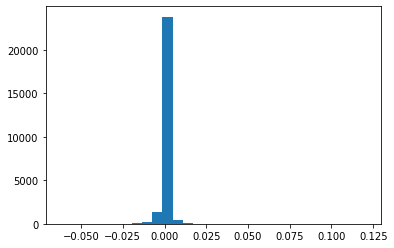

In [69]:
plt.hist(p, bins = 30)

In [70]:
A@(p*sum_of_p)

array([2.60085975e-05, 1.03437416e-02, 8.77138197e-04, ...,
       1.86130426e-05, 1.86130426e-05, 1.86130426e-05])

In [71]:
sum_of_p

2.3951882403392766

In [72]:
b

array([7.68846346e-06, 7.68846346e-06, 7.68846346e-06, ...,
       7.68846346e-06, 7.68846346e-06, 7.68846346e-06])